# UniversityHack 2021 - Atmira Stock Prediction - Script Producción
-----

In [1]:
import pandas as pd
import numpy as np

import tensorflow as tf

import keras
from keras import models
from keras import activations

from datetime import datetime
from matplotlib import pyplot as plt

from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

In [208]:
import gc
gc.collect()

17684

In [3]:
# If you plan to run this notebook, it is recomended you have at least one GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# Data Preprocessing

Before we do anything with our data, we perform an extensive data preprocessing step according to our EDA findings:

1. Drop the `antiguedad` variable as we do not find it contains sensible data.
2. Change the dates to the correct year we estimate the data is from to match the weekday periodicity missmatch.
3. Scale the visitas x5 for the period preceding 2019-1-24 as we've found that it was tampered with.
4. One-hot encode several fields to improve ML performance
5. Augment our data with weekday and monthly sin/cos periodicty helpers. Will help the ML system detect periodic patterns.

We also run a price filling algorithm on the `Modelar` dataset to fill in the Price of items as specified in the instructions.

In [82]:
def data_preprocessing(df):
    # General cleaning
    df = df.drop_duplicates()
    df.dropna(how='any', inplace=True)
    df = df.drop(['antiguedad'], axis=1, errors='ignore')
    
    # Fix years
    df.loc[df.fecha.dt.year == 2015, "fecha"] = df["fecha"] + pd.offsets.DateOffset(year=2018)
    df.loc[df.fecha.dt.year == 2016, "fecha"] = df["fecha"] + pd.offsets.DateOffset(year=2019)
    
    # Fix visitas
    pre = df.fecha <= datetime(2019,1,24)
    post = df.fecha > datetime(2019,1,24)
    
    df['visitas_scl'] = np.concatenate([
        df[pre].visitas * 5,
        df[post].visitas * 1,
        ], axis=0
    )
    
    # Data Augmentation
    df['dia_atipico_neg'] = (df.dia_atipico == -1).astype(int)
    df['dia_atipico_neu'] = (df.dia_atipico == 0).astype(int)
    df['dia_atipico_pos'] = (df.dia_atipico == 1).astype(int)

    df['estado_no_rotura'] = (df.estado == 'No Rotura').astype(int)
    df['estado_transito'] = (df.estado == 'Transito').astype(int)
    df['estado_rotura'] = (df.estado == 'Rotura').astype(int)
    
    df['categoria_dos'] = df.categoria_dos.astype('str').str.replace('.0','')
    df_categoria_uno_onehot = pd.get_dummies(df.categoria_uno, prefix='categoria_uno_')
    df_categoria_dos_onehot = pd.get_dummies(df.categoria_dos, prefix='categoria_dos_')
    
    df_fe = pd.concat([df, df_categoria_uno_onehot, df_categoria_dos_onehot], axis=1)
    df_fe = df_fe.drop(['estado', 'dia_atipico', 'categoria_uno', 'categoria_dos'], axis=1, errors='ignore')
    
    # Cyclical week and month spinners
    df_weekday = df_fe.fecha.dt.weekday
    df_month = df_fe["fecha"].dt.month + (df_fe["fecha"].dt.day / df_fe["fecha"].dt.days_in_month)
    
    df_fe['weekday_sin'] = np.sin(df_weekday * (2*np.pi/7))
    df_fe['weekday_cos'] = np.cos(df_weekday * (2*np.pi/7))
    df_fe['month_sin'] = np.sin((df_month-1) * (2*np.pi/12))
    df_fe['month_cos'] = np.cos((df_month-1) * (2*np.pi/12))
    
    return df_fe

def data_preprocessing_2(df):
    # General cleaning
    print('Dropping duplicates')
    df = df.drop_duplicates()
    df = df.drop(['antiguedad'], axis=1, errors='ignore')
    
    print('Fixing duplicate entries for campaign days')
    df = df.groupby(['fecha','id']).max().reset_index()
    
    print('Fixing dates')
    df.loc[df.fecha.dt.year == 2015, "fecha"] = df["fecha"] + pd.offsets.DateOffset(year=2018)
    df.loc[df.fecha.dt.year == 2016, "fecha"] = df["fecha"] + pd.offsets.DateOffset(year=2019)
    
    print('Fixing visits')
    df['visitas_scl'] = np.where(
        df['fecha'] <= datetime(2019,1,24),
        df["visitas"] * 5,
        df["visitas"] * 1
    )
    df["visitas_scl"] = pd.to_numeric(df['visitas_scl'])
    
    # Data Augmentation
    df['dia_atipico_neg'] = (df.dia_atipico == -1).astype(int)
    df['dia_atipico_neu'] = (df.dia_atipico == 0).astype(int)
    df['dia_atipico_pos'] = (df.dia_atipico == 1).astype(int)

    df['estado_no_rotura'] = (df.estado == 'No Rotura').astype(int)
    df['estado_transito'] = (df.estado == 'Transito').astype(int)
    df['estado_rotura'] = (df.estado == 'Rotura').astype(int)
    
    # Drop the old columns
    df = df.drop(['estado', 'dia_atipico'], axis=1, errors='ignore')
    
    # Prepare categorias for Embedding
    df['categoria_uno'] = pd.Series(list(map(ord, df.categoria_uno))) - ord('A')+1
    df['categoria_dos'] = df.categoria_dos.fillna(0).astype(int)

    print('One-hot encoding of Category')
    df_categoria_uno_onehot = pd.get_dummies(df.categoria_uno, prefix='categoria_uno_')
    df_categoria_dos_onehot = pd.get_dummies(df.categoria_dos, prefix='categoria_dos_')
    
    df = pd.concat([df, df_categoria_uno_onehot, df_categoria_dos_onehot], axis=1)

    # Cyclical week and month spinners
    df_weekday = df.fecha.dt.weekday
    df_month = df["fecha"].dt.day / df["fecha"].dt.days_in_month
    df_year = (df["fecha"].dt.month - 1) + (df["fecha"].dt.day / df["fecha"].dt.days_in_month)
    
    df['weekday_sin'] = np.sin(df_weekday * (2*np.pi/7))
    df['weekday_cos'] = np.cos(df_weekday * (2*np.pi/7))
    df['month_sin'] = np.sin(df_month * (2*np.pi))
    df['month_cos'] = np.cos(df_month * (2*np.pi))
    df['year_sin'] = np.sin((df_year-1) * (2*np.pi/12))
    df['year_cos'] = np.cos((df_year-1) * (2*np.pi/12))
    
    print('clearing NANs')
    df.dropna(how='any', inplace=True)
    
    return df

def data_preprocessing_fill_price(df):
    total = len(df.id.unique())

    for i, pid in enumerate(df.id.unique()):
        # This product's entries
        df_prod = df[df.id == pid]

        # Fillforward, then back to cover the first few lines
        df_prod = df_prod.fillna(method='ffill').fillna(method='bfill')

        # Save to DF
        df.loc[df_prod.index] = df_prod

        clear_output(wait=True)
        print("Filled %.1f%% of the Dataframe" % (i/total * 100))
        

In [83]:
df_modelar = pd.read_csv('./data/Modelar_UH2021_filled_precio_2.txt',sep='|', parse_dates=[0])

print(df_modelar.shape)
df_modelar = data_preprocessing_2(df_modelar)
print(df_modelar.shape)
df_modelar[:5]

(4045022, 11)
Dropping duplicates
Fixing duplicate entries for campaign days
Fixing dates
Fixing visits
One-hot encoding of Category
clearing NANs
(2029816, 217)


,fecha,id,visitas,categoria_uno,categoria_dos,precio,campaña,unidades_vendidas,visitas_scl,dia_atipico_neg,...,categoria_dos__340,categoria_dos__341,categoria_dos__342,categoria_dos__343,weekday_sin,weekday_cos,month_sin,month_cos,year_sin,year_cos
0,2018-06-01,21972,0,3,75,5.84,0,0,0,0,...,0,0,0,0,-0.433884,-0.900969,0.207912,0.978148,0.857167,-0.515038
1,2018-06-01,23910,5,3,170,6.07,0,3,25,0,...,0,0,0,0,-0.433884,-0.900969,0.207912,0.978148,0.857167,-0.515038
2,2018-06-01,24306,13,1,46,7.85,0,0,65,0,...,0,0,0,0,-0.433884,-0.900969,0.207912,0.978148,0.857167,-0.515038
3,2018-06-01,27144,15,5,230,6.12,0,0,75,0,...,0,0,0,0,-0.433884,-0.900969,0.207912,0.978148,0.857167,-0.515038
4,2018-06-01,27504,7,3,157,10.74,0,0,35,0,...,0,0,0,0,-0.433884,-0.900969,0.207912,0.978148,0.857167,-0.515038


In [88]:
df_estimar = pd.read_csv('./data/Estimar2.txt', parse_dates=[0], sep='|', decimal=',', engine="python")
df_estimar['categoria_dos'] = df_estimar.categoria_dos.replace('-','0')

print(df_estimar.shape)
df_estimar = data_preprocessing_2(df_estimar)
print(df_estimar.shape)

df_estimar[:5]

(212841, 10)
Dropping duplicates
Fixing duplicate entries for campaign days
Fixing dates
Fixing visits
One-hot encoding of Category
clearing NANs
(212841, 197)


,fecha,id,visitas,categoria_uno,categoria_dos,precio,campaña,visitas_scl,dia_atipico_neg,dia_atipico_neu,...,categoria_dos__340,categoria_dos__341,categoria_dos__342,categoria_dos__343,weekday_sin,weekday_cos,month_sin,month_cos,year_sin,year_cos
0,2019-10-01,21972,5,3,75,5.84,0,5,0,1,...,0,0,0,0,0.781831,0.62349,0.201299,0.97953,-0.874347,-0.485302
1,2019-10-01,23910,35,3,170,6.07,0,35,0,1,...,0,0,0,0,0.781831,0.62349,0.201299,0.97953,-0.874347,-0.485302
2,2019-10-01,27144,105,5,230,5.92,0,105,0,1,...,0,0,0,0,0.781831,0.62349,0.201299,0.97953,-0.874347,-0.485302
3,2019-10-01,30014,25,3,63,5.84,0,25,0,1,...,0,0,0,0,0.781831,0.62349,0.201299,0.97953,-0.874347,-0.485302
4,2019-10-01,30522,25,3,76,7.41,0,25,0,1,...,0,0,0,0,0.781831,0.62349,0.201299,0.97953,-0.874347,-0.485302


## Select all columns that appear in both DataFrames

Since not all categories appear in `Estimar`, we perform a set intersect to grab the matching columns. After this we are finally ready to build our model.

In [89]:
df_modelar_columns = set(df_modelar.columns)
df_estimar_columns = set(df_estimar.columns)
df_common_columns = df_modelar_columns & df_estimar_columns

# Reorder fecha to first column
df_common_columns.remove('fecha')

df_modelar = df_modelar[['fecha'] + list(df_common_columns) + ['unidades_vendidas']]
df_estimar = df_estimar[['fecha'] + list(df_common_columns)]

In [90]:
df_modelar.to_csv('data/Modelar_UH2021_prod.txt', index=False)
df_estimar.to_csv('data/Estimar2_prod.txt', index=False)

### Load pre-compiled data here

In [87]:
df_modelar = pd.read_csv('data/Modelar_UH2021_prod.txt', parse_dates=[0])
df_estimar = pd.read_csv('data/Estimar2_prod.txt', parse_dates=[0], decimal=',')

In [209]:
plt.figure(figsize=[12,8])
df_modelar.groupby('fecha').sum().visitas_scl.plot()

MemoryError: Unable to allocate 2.87 GiB for an array with shape (2029816, 190) and data type float64

<Figure size 864x576 with 0 Axes>

# Machine Learning Pipeline

We will be using Keras to build a regression Neural Network to predict the target label. The steps will be as follows:

1. Time Series analysis of the Seasonality / Trend
    - Extract weekly seasonality
    - Extract month-of-the-year trend
1. Determine the X and y columns
2. Split our data in Train / Test datasets wtih 0.9 / 0.1 weights
3. Transform our data to be easier for the NN to process
4. Sanity check our data before we proceed
5. Define the NN model to use:
    - Layer types
    - Number of neurons per layer
    - Output layer
    - Optimization function
    - Target loss
6. Execute the NN training on a GPU



## TimeSeries Analysis

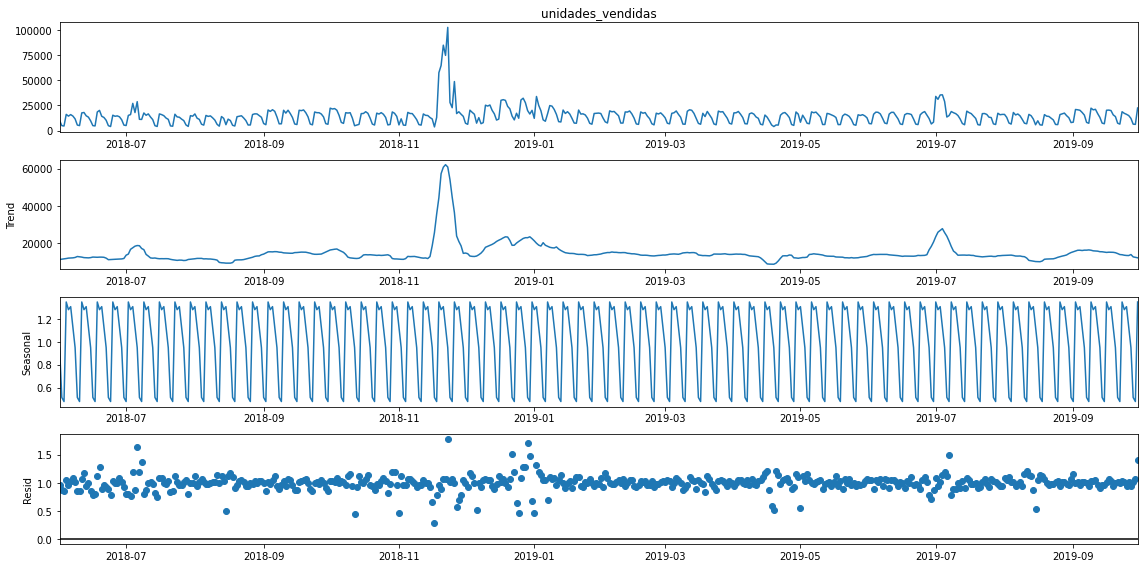

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose

df_modelar_day = df_modelar.groupby('fecha').sum().asfreq('D')

ts_decompose = seasonal_decompose(df_modelar_day.unidades_vendidas, model='multiplicative', extrapolate_trend='freq')

plt.rcParams.update({'figure.figsize': (16,8)})
ts_decompose.plot()
plt.show()

In [171]:
# Select Mon-Sun
ts_seasonal = ts_decompose.seasonal[3:10]

ts_trend = ts_decompose.trend.resample('M').mean()
ts_trend = ts_trend / ts_trend.mean()
# Select Jan-Dec
trend_month_year = pd.concat([ts_trend[7:], ts_trend[4:7]])

month_to_factor = dict(zip(range(12), trend_month_year))
weekday_to_factor = dict(zip(range(7), ts_seasonal))

df_modelar['ts_seasonal'] = df_modelar.fecha.dt.weekday.map(weekday_to_factor)
df_modelar['ts_trend'] = (df_modelar.fecha.dt.month-1).map(month_to_factor)

df_modelar[['fecha', 'id', 'ts_seasonal', 'ts_trend']][:3]

,fecha,id,ts_seasonal,ts_trend
0,2018-06-01,21972,0.948618,0.947512
1,2018-06-01,23910,0.948618,0.947512
2,2018-06-01,24306,0.948618,0.947512


### Feature Engineering

In [169]:
product_std = dict()
product_mean = dict()
product_ratio = dict()

for p in df_modelar.id.unique():
    df_p = df_modelar[df_modelar.id == p].unidades_vendidas
    product_std[p] = df_p.std()
    product_mean[p] = df_p.mean()
    product_ratio[p] = df_p.std() / df_p.mean()

df_modelar['unidades_mean'] = df_modelar.id.map(product_mean)
df_modelar['unidades_std'] = df_modelar.id.map(product_std)
df_modelar['unidades_ratio'] = df_modelar.id.map(product_ratio)

## Data handling - Train / Test Split

In [45]:
# ID_TO_DIM = {}
# DIM_TO_ID = {}

# for i, iid in enumerate(sorted(df_modelar.id.unique())):
#     ID_TO_DIM[iid] = i+1
#     DIM_TO_ID[i+1] = iid
    
# df_modelar['id_dim'] = df_modelar.id.replace(ID_TO_DIM)
# df_estimar['id_dim'] = df_estimar.id.replace(ID_TO_DIM)

In [172]:
from sklearn.model_selection import train_test_split

X_cols = [
#     'id_dim',
    'campaña',
    'dia_atipico_neg', 'dia_atipico_neu', 'dia_atipico_pos',
    'estado_rotura', 'estado_no_rotura', 'estado_transito',
    'precio', 'visitas_scl',
    'weekday_sin', 'weekday_cos',
    'month_sin', 'month_cos',
    'year_sin', 'year_cos',
    'ts_seasonal', 'ts_trend',
    'unidades_mean', 'unidades_std', 'unidades_ratio'
]

X_cols_cats = [
    'categoria_uno', 'categoria_dos'
]

X_cols_onehot_cats = [
    'categoria_uno__2',    'categoria_uno__3',    'categoria_uno__12',    'categoria_uno__9',
    'categoria_uno__1',    'categoria_uno__14',   'categoria_uno__11',
    'categoria_uno__6',    'categoria_uno__15',   'categoria_uno__5',    'categoria_uno__8',
    'categoria_uno__4',    'categoria_uno__7',

    'categoria_dos__0',    'categoria_dos__10',    'categoria_dos__101',    'categoria_dos__103',
    'categoria_dos__105',    'categoria_dos__108',    'categoria_dos__109',    'categoria_dos__114',
    'categoria_dos__115',    'categoria_dos__116',    'categoria_dos__120',    'categoria_dos__122',
    'categoria_dos__123',    'categoria_dos__124',    'categoria_dos__125',    'categoria_dos__127',
    'categoria_dos__131',    'categoria_dos__133',    'categoria_dos__135',    'categoria_dos__136',
    'categoria_dos__137',    'categoria_dos__14',    'categoria_dos__143',    'categoria_dos__144',
    'categoria_dos__145',    'categoria_dos__150',    'categoria_dos__155',    'categoria_dos__156',
    'categoria_dos__157',    'categoria_dos__158',    'categoria_dos__16',    'categoria_dos__160',
    'categoria_dos__161',    'categoria_dos__165',    'categoria_dos__170',    'categoria_dos__174',
    'categoria_dos__175',    'categoria_dos__179',    'categoria_dos__180',    'categoria_dos__182',
    'categoria_dos__183',    'categoria_dos__186',    'categoria_dos__188',    'categoria_dos__192',
    'categoria_dos__195',    'categoria_dos__197',    'categoria_dos__199',    'categoria_dos__2',
    'categoria_dos__20',    'categoria_dos__200',    'categoria_dos__201',    'categoria_dos__202',
    'categoria_dos__203',    'categoria_dos__205',    'categoria_dos__206',    'categoria_dos__207',
    'categoria_dos__212',    'categoria_dos__22',    'categoria_dos__221',    'categoria_dos__223',
    'categoria_dos__224',    'categoria_dos__226',    'categoria_dos__228',    'categoria_dos__229',
    'categoria_dos__23',    'categoria_dos__230',    'categoria_dos__233',    'categoria_dos__235',
    'categoria_dos__236',    'categoria_dos__237',    'categoria_dos__238',    'categoria_dos__239',
    'categoria_dos__243',    'categoria_dos__245',    'categoria_dos__247',    'categoria_dos__248',
    'categoria_dos__249',    'categoria_dos__253',    'categoria_dos__255',    'categoria_dos__256',
    'categoria_dos__258',    'categoria_dos__259',    'categoria_dos__263',    'categoria_dos__264',
    'categoria_dos__266',    'categoria_dos__267',    'categoria_dos__268',    'categoria_dos__269',
    'categoria_dos__27',    'categoria_dos__270',    'categoria_dos__271',    'categoria_dos__274',
    'categoria_dos__276',    'categoria_dos__277',    'categoria_dos__278',    'categoria_dos__28',
    'categoria_dos__282',    'categoria_dos__285',    'categoria_dos__286',    'categoria_dos__289',
    'categoria_dos__29',    'categoria_dos__292',    'categoria_dos__295',    'categoria_dos__296',
    'categoria_dos__298',    'categoria_dos__30',    'categoria_dos__303',    'categoria_dos__304',
    'categoria_dos__305',    'categoria_dos__307',    'categoria_dos__308',    'categoria_dos__312',
    'categoria_dos__314',    'categoria_dos__315',    'categoria_dos__316',    'categoria_dos__319',
    'categoria_dos__32',    'categoria_dos__323',    'categoria_dos__326',    'categoria_dos__329',
    'categoria_dos__333',    'categoria_dos__336',    'categoria_dos__338',    'categoria_dos__34',
    'categoria_dos__340',    'categoria_dos__341',    'categoria_dos__342',    'categoria_dos__343',
    'categoria_dos__36',    'categoria_dos__37',    'categoria_dos__38',    'categoria_dos__39',
    'categoria_dos__42',    'categoria_dos__43',    'categoria_dos__44',    'categoria_dos__45',
    'categoria_dos__46',    'categoria_dos__49',    'categoria_dos__5',    'categoria_dos__50',
    'categoria_dos__51',    'categoria_dos__57',    'categoria_dos__63',    'categoria_dos__65',
    'categoria_dos__66',    'categoria_dos__67',    'categoria_dos__69',    'categoria_dos__7',
    'categoria_dos__71',    'categoria_dos__72',    'categoria_dos__73',    'categoria_dos__75',
    'categoria_dos__76',    'categoria_dos__78',    'categoria_dos__8',    'categoria_dos__80',
    'categoria_dos__82',    'categoria_dos__84',    'categoria_dos__85',    'categoria_dos__86',
    'categoria_dos__92',    'categoria_dos__93',    'categoria_dos__95',    'categoria_dos__97'
]

y_cols = ['unidades_vendidas']

product_intersection = df_modelar.id.isin(df_estimar.id)

X = df_modelar[product_intersection][X_cols + X_cols_onehot_cats]
y = df_modelar[product_intersection][y_cols]

X = X.astype(np.float32)
y = y.astype(np.float32)

# int_cols = ['id_dim']
# X[int_cols] = X[int_cols].astype(np.int32)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=0)

## Fit Scalers to the Train data

In [173]:
from sklearn.preprocessing import RobustScaler

class NoOpScaler(object):
    def fit_transform(self, data):
        return data.astype(np.float32);
    def transform(self, data):
        return data.astype(np.float32); 
    def inverse_transform(self, data):
        return data.astype(np.float32);

# X Scaling
X_scaler = RobustScaler(quantile_range=[5,95])

X_train_scl = X_train
X_test_scl = X_test

X_cols_to_scl = ['precio', 'visitas_scl', 'unidades_std', 'unidades_mean', 'unidades_ratio']

X_train_scl[X_cols_to_scl] = X_scaler.fit_transform(X_train[X_cols_to_scl])
X_test_scl[X_cols_to_scl] = X_scaler.transform(X_test[X_cols_to_scl])

# y scaling

# TODO: Disabled y-scaler to use real Loss
y_scaler = RobustScaler(quantile_range=[5,95])
# y_scaler = NoOpScaler()

y_train_scl = y_scaler.fit_transform(y_train)
y_test_scl = y_scaler.transform(y_test)

In [174]:
# Inspect our data
print(X_train.shape)
print(X_test.shape)
X_train_scl.describe().round(2)

(1199188, 197)
(133244, 197)


,campaña,dia_atipico_neg,dia_atipico_neu,dia_atipico_pos,estado_rotura,estado_no_rotura,estado_transito,precio,visitas_scl,weekday_sin,...,categoria_dos__8,categoria_dos__80,categoria_dos__82,categoria_dos__84,categoria_dos__85,categoria_dos__86,categoria_dos__92,categoria_dos__93,categoria_dos__95,categoria_dos__97
count,1199188.00,1199188.00,1199188.00,1199188.0,1199188.00,1199188.00,1199188.00,1199188.00,1199188.00,1199188.00,...,1199188.00,1199188.00,1199188.00,1199188.00,1199188.00,1199188.00,1199188.00,1199188.00,1199188.00,1199188.00
mean,0.00,0.03,0.87,0.1,0.09,0.90,0.01,0.12,0.19,-0.00,...,0.00,0.00,0.07,0.01,0.01,0.01,0.00,0.00,0.00,0.01
std,0.07,0.18,0.34,0.3,0.28,0.29,0.11,0.33,1.21,0.71,...,0.03,0.03,0.25,0.08,0.12,0.08,0.04,0.04,0.02,0.09
min,0.00,0.00,0.00,0.0,0.00,0.00,0.00,-0.25,-0.08,-0.97,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,1.00,0.0,0.00,1.00,0.00,-0.11,-0.06,-0.78,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,0.00,0.00,1.00,0.0,0.00,1.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,0.00,0.00,1.00,0.0,0.00,1.00,0.00,0.27,0.14,0.78,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,1.00,1.00,1.00,1.0,1.00,1.00,1.00,2.23,500.15,0.97,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [35]:
# Visual inspection of y values
pd.concat([
    pd.Series(y_train[::10].values[:,0]),
    pd.Series(y_train_scl[::10][:,0]),
    pd.Series(y_scaler.inverse_transform(y_train_scl[::10])[:,0])
], axis=1)[::71][:7]

,0,1,2
0,0.0,0.0,0.0
71,24.0,1.6,24.0
142,0.0,0.0,0.0
213,0.0,0.0,0.0
284,0.0,0.0,0.0
355,0.0,0.0,0.0
426,0.0,0.0,0.0


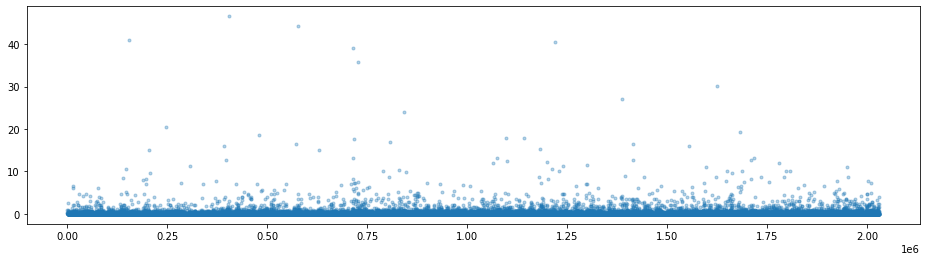

In [175]:
# Target variable spead
plt.figure(figsize=[16,4])
# plt.ylim([0,15])
plt.scatter(X_train.index[::50], y_train_scl[::50], marker=".", alpha=0.33)

# NN Model

## Functional KERAS Archictecture

Using Resnet's "Residual" network idea, we connnect the input layers to the output layer near the end.

In [176]:
from keras import backend as K
from tensorflow.python.ops import math_ops

y_mean_total = tf.constant(y_train_scl.mean(), dtype=np.float32)

def score_metric(y_true, y_pred):
#     y_true = y_scaler.inverse_transform(y_true)
#     y_pred = y_scaler.inverse_transform(y_pred)
    
    mse = K.mean(K.square(y_true-y_pred))
    rrmse = K.sqrt(mse) / y_mean_total
    
    cf = K.mean(K.clip((y_pred-y_true)*1000, 0, 1))
    
    return 0.7 * rrmse + 0.3 * (1-cf)

def cf_loss(y_true, y_pred):
    error = tf.keras.losses.MAE(y_true, y_pred)
    
    cf = K.mean(K.clip((y_pred-y_true)*1000, 0, 1))
    
    return 0.9 * error + 0.1 * cf


In [33]:
nn_dim = len(X.columns) - 1

id_embedding_size = 8
cat_one_embedding_size = 6
cat_two_embedding_size = 10

nn_total_dims = nn_dim + id_embedding_size

# NN Inputs
id_input = keras.Input(shape=(1,), name='id_input')
# cat_one_input = keras.Input(shape=(1,), name='cat_one_input')
# cat_two_input = keras.Input(shape=(1,), name='cat_two_input')
nn_input = keras.Input(shape=(nn_dim,), name='nn_input')

# Embedding and Flatten layers
id_embedding = keras.layers.Embedding(
    input_length=1,
    input_dim=X_train.id_dim.max() + 1,
    output_dim=id_embedding_size, 
    name='id_embedding',
    embeddings_initializer="he_normal",
#     embeddings_regularizer=keras.regularizers.l2(1e-6)
)(id_input)

# cat_one_embedding = keras.layers.Embedding(X_train.categoria_uno_int.max()+1, cat_one_embedding_size, 
#     input_length=1, name='catone_embedding',
#     embeddings_initializer="he_normal",
#     embeddings_regularizer=keras.regularizers.l2(1e-6))(cat_one_input)

# cat_two_embedding = keras.layers.Embedding(X_train.categoria_dos.max()+1, cat_two_embedding_size, 
#     input_length=1, name='cattwo_embedding',
#     embeddings_initializer="he_normal",
#     embeddings_regularizer=keras.regularizers.l2(1e-6))(cat_two_input)


# Concatenate to single vector
concatenated = keras.layers.Concatenate(name="concat_vector")([
    keras.layers.Flatten()(id_embedding),
#     keras.layers.Flatten()(cat_one_embedding),
#     keras.layers.Flatten()(cat_two_embedding),
    keras.layers.Flatten()(nn_input)
])

# Dense Blocks
current_layer = concatenated

for i in range(2,5):
#     dense_block = keras.layers.BatchNormalization()(current_layer)
    dense_block = keras.layers.Dropout(0.1)(current_layer)
    dense_block = keras.layers.Dense(
        nn_total_dims * 8,
        activation=tf.keras.layers.LeakyReLU(alpha=0.3)
    )(dense_block)
    
    current_layer = dense_block

# Final classifier
dense_final = keras.layers.Dense(nn_total_dims * 4, activation="relu", name="dense_final")(current_layer)
dense_final = keras.layers.Dense(nn_total_dims * 2, activation="relu", name="dense_final2")(dense_final)

# Bypass layers from before
bypass_concat = keras.layers.Concatenate(name="bypass")([
    dense_final,
    keras.layers.Dense(nn_total_dims)(concatenated)
])


output = keras.layers.Dense(1, activation="linear", name="output")(bypass_concat)

model = keras.Model(
    inputs = [
        id_input,
#         cat_one_input,
#         cat_two_input,
        nn_input
    ],
    outputs = output,
)
model.summary()

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
id_input (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
id_embedding (Embedding)        (None, 1, 8)         33352       id_input[0][0]                   
__________________________________________________________________________________________________
nn_input (InputLayer)           [(None, 192)]        0                                            
__________________________________________________________________________________________________
flatten_8 (Flatten)             (None, 8)            0           id_embedding[0][0]               
_______________________________________________________________________________________

### Final model setup

In [34]:
model.compile(loss="mae", optimizer=keras.optimizers.Adam(lr=0.01), metrics=[score_metric])

# Early Stopping
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
# Store best model
mc = keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

train_data = [
    X_train.id_dim,
#     X_train.categoria_uno_int,
#     X_train.categoria_dos,
    X_train[X_train.columns.drop(['id_dim'])]
]
test_data = [
    X_test.id_dim,
#     X_test.categoria_uno_int,
#     X_test.categoria_dos,
    X_test[X_test.columns.drop(['id_dim'])]
]

### Model Training

In [35]:
# Train model
history = model.fit(train_data, y_train_scl, epochs=1000, batch_size=256,
    callbacks=[es, mc],
    validation_data=(test_data, y_test_scl)
)

Epoch 1/1000
4682/4685 [============================>.] - ETA: 0s - loss: 0.4384 - score_metric: 2.8346
Epoch 00001: val_loss improved from inf to 0.22516, saving model to best_model.h5
4685/4685 [==============================] - 31s 7ms/step - loss: 0.4383 - score_metric: 2.8342 - val_loss: 0.2252 - val_score_metric: 2.2366
Epoch 2/1000
4681/4685 [============================>.] - ETA: 0s - loss: 7.5612 - score_metric: 39.5306
Epoch 00002: val_loss improved from 0.22516 to 0.22266, saving model to best_model.h5
4685/4685 [==============================] - 30s 6ms/step - loss: 7.5560 - score_metric: 39.4984 - val_loss: 0.2227 - val_score_metric: 2.1144
Epoch 3/1000
4678/4685 [============================>.] - ETA: 0s - loss: 0.2237 - score_metric: 2.1461
Epoch 00003: val_loss improved from 0.22266 to 0.22079, saving model to best_model.h5
4685/4685 [==============================] - 31s 7ms/step - loss: 0.2237 - score_metric: 2.1458 - val_loss: 0.2208 - val_score_metric: 2.0961
Epoch 

## Old Neural Network architecture

In [177]:
from keras.layers import Dense, Dropout, BatchNormalization

FEAT_DIM = len(X.columns)

gc.collect()

leakyReLU = tf.keras.layers.LeakyReLU

dense_kwargs = {"activation":leakyReLU(alpha=0.2), "kernel_initializer":tf.keras.initializers.HeNormal()}

model = models.Sequential()

model.add(Dense(FEAT_DIM*10, input_dim=FEAT_DIM, **dense_kwargs))
# model.add(Dropout(0.2))

model.add(Dense(FEAT_DIM*8, **dense_kwargs))
# model.add(Dropout(0.1))

# model.add(BatchNormalization())
model.add(Dense(FEAT_DIM*5, **dense_kwargs))
model.add(Dense(FEAT_DIM*4, **dense_kwargs))
model.add(Dense(FEAT_DIM*3, **dense_kwargs))
model.add(Dense(FEAT_DIM*2, **dense_kwargs))
# model.add(Dense(FEAT_DIM*16, activation='relu'))
# OUTPUT
model.add(Dense(1, activation="linear"))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 1970)              390060    
_________________________________________________________________
dense_8 (Dense)              (None, 1576)              3106296   
_________________________________________________________________
dense_9 (Dense)              (None, 985)               1553345   
_________________________________________________________________
dense_10 (Dense)             (None, 788)               776968    
_________________________________________________________________
dense_11 (Dense)             (None, 591)               466299    
_________________________________________________________________
dense_12 (Dense)             (None, 394)               233248    
_________________________________________________________________
dense_13 (Dense)             (None, 1)                

In [178]:
# Early Stopping
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
# Store best model
mc = keras.callbacks.ModelCheckpoint('best_model_old.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

model.compile(loss="mae", optimizer='adam', metrics=[])

history = model.fit(X_train_scl, y_train_scl, epochs=1000, batch_size=256,
    callbacks=[es, mc],
    validation_data=(X_test_scl, y_test_scl)
)

Epoch 1/1000
4676/4685 [============================>.] - ETA: 0s - loss: 0.2020
Epoch 00001: val_loss improved from inf to 0.18790, saving model to best_model_old.h5
4685/4685 [==============================] - 26s 6ms/step - loss: 0.2020 - val_loss: 0.1879
Epoch 2/1000
4678/4685 [============================>.] - ETA: 0s - loss: 0.1856
Epoch 00002: val_loss improved from 0.18790 to 0.18090, saving model to best_model_old.h5
4685/4685 [==============================] - 26s 5ms/step - loss: 0.1856 - val_loss: 0.1809
Epoch 3/1000
4681/4685 [============================>.] - ETA: 0s - loss: 0.1924
Epoch 00003: val_loss did not improve from 0.18090
4685/4685 [==============================] - 26s 5ms/step - loss: 0.1923 - val_loss: 0.1846
Epoch 4/1000
4678/4685 [============================>.] - ETA: 0s - loss: 0.2149
Epoch 00004: val_loss improved from 0.18090 to 0.17850, saving model to best_model_old.h5
4685/4685 [==============================] - 26s 6ms/step - loss: 0.2148 - val_loss

## Plot the NN training results

This plot will help us identify if our NN is overfitting or if the training stalled. We can see a smooth curve downwards indicating our NN trained nicely.

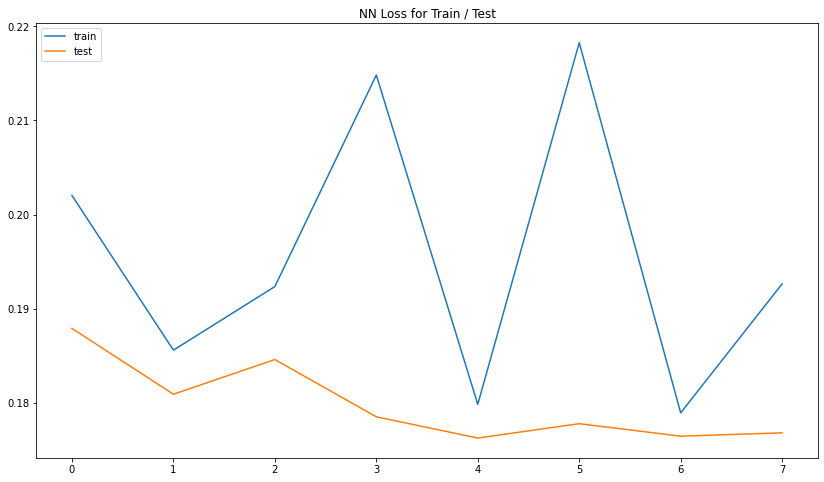

In [179]:
plt.figure(figsize=[14,8])
# plt.ylim((0.85,0.98))

plt.title('NN Loss for Train / Test')

train_acc = history.history['loss'][:]
test_acc = history.history['val_loss'][:]

plt.plot(train_acc)
plt.plot(test_acc)
# plt.plot([max(train_acc)] * len(train_acc))
# plt.plot([max(test_acc)] * len(test_acc))

plt.legend(['train', 'test'], loc='upper left')

## Model Scoring

Before we execute our model with the `Estimar` dataset, lets check the expected performance of our model. We want to center our attention to two aspects:

1. General predictive power across the entire year
2. Predictive score around the interest interval of Black friday and Christmas.
    - This will be the most correlated value to our expected `Estimar` score.

### Scoring Functions

These were defined in the documentation for this project.

In [180]:
def rrmse(y,yhat):
    return np.sqrt(np.sum(np.power(y-yhat,2))/y.shape[0])/y.mean()

def cf(y,yhat):
    no_rotura=np.where(yhat >= y, 1, 0)
    return no_rotura.mean()

def score(y,yhat):
    return (0.7*rrmse(y,yhat))+(.3*(1-cf(y,yhat)))

#### Use Trained model as is

In [38]:
# trained_model = model
y_hat = model.predict(test_data)
y_hat_real = y_scaler.inverse_transform(y_hat)
y_hat_real[y_hat_real < 0] = 0

#### Load Best model

In [181]:
from keras.models import load_model

# model = load_model('best_model.h5', compile=False)
model = load_model('best_model_old.h5', compile=False, custom_objects={'LeakyReLU':tf.keras.layers.LeakyReLU})

y_hat = model.predict(X_test)
y_hat_real = y_scaler.inverse_transform(y_hat)
y_hat_real[y_hat_real < 0] = 0

## Bruteforce Optimun Parameters

TODO:Description

In [182]:
best_score = 999

for mul in np.linspace(0.8,1.2,20):
    for add in np.linspace(0,5,20):
        for pw in np.linspace(0.95,1.20,20):
            
            yhr = (np.power(y_hat_real, pw) * mul + add).round(0)
            scr = score(y_test.values, yhr)
            
            if scr < best_score:
                best_score = scr
                print("*%.2f +%.2f ^%.2f = %.5f "%(mul, add, pw, scr))
                _pw = pw
                _mul = mul
                _add = add

def optimize_transform(y_pred):
    return (np.power(y_pred, _pw) * _mul + _add).round(0)


*0.80 +0.00 ^0.95 = 2.24578 
*0.80 +0.00 ^0.96 = 2.21442 
*0.80 +0.00 ^0.98 = 2.18354 
*0.80 +0.00 ^0.99 = 2.15367 
*0.80 +0.00 ^1.00 = 2.12605 
*0.80 +0.00 ^1.02 = 2.10145 
*0.80 +0.00 ^1.03 = 2.08079 
*0.80 +0.00 ^1.04 = 2.06577 
*0.80 +0.00 ^1.06 = 2.05753 
*0.80 +0.26 ^1.06 = 2.05231 
*0.80 +0.53 ^1.04 = 2.04936 
*0.80 +0.53 ^1.06 = 2.04198 
*0.80 +0.79 ^1.06 = 2.03722 
*0.80 +1.05 ^1.06 = 2.03278 
*0.80 +1.32 ^1.06 = 2.02867 
*0.80 +1.84 ^1.06 = 2.02748 
*0.80 +2.11 ^1.06 = 2.02437 
*0.80 +2.37 ^1.06 = 2.02093 
*0.80 +2.63 ^1.04 = 2.01668 
*0.80 +2.63 ^1.06 = 2.01314 
*0.80 +2.89 ^1.06 = 2.01188 
*0.80 +3.16 ^1.06 = 2.01148 
*0.80 +3.42 ^1.06 = 2.01113 
*0.84 +2.63 ^1.04 = 2.01081 
*0.84 +2.89 ^1.04 = 2.01048 
*0.84 +3.16 ^1.04 = 2.00997 
*0.86 +2.89 ^1.04 = 2.00967 
*0.86 +3.16 ^1.04 = 2.00936 
*0.91 +2.63 ^1.03 = 2.00879 
*0.91 +2.89 ^1.03 = 2.00839 
*0.91 +3.16 ^1.03 = 2.00804 
*0.93 +2.89 ^1.03 = 2.00799 
*0.95 +2.89 ^1.02 = 2.00786 
*0.97 +2.63 ^1.02 = 2.00681 
*0.99 +2.63 ^1

In [183]:
_pw, _mul, _add

(0.9894736842105263, 1.1157894736842104, 2.631578947368421)

## Generate Predictions for Validation

In [184]:
df_y_hat = pd.DataFrame()

df_y_hat['id'] = df_modelar.loc[X_test.index].id
df_y_hat['fecha'] = df_modelar.loc[X_test.index].fecha
# df_y_hat['visitas'] = X_test.visitas_scl
df_y_hat['y_test'] = y_test
df_y_hat['y_hat_raw'] = y_hat_real
df_y_hat['y_hat_opt'] = optimize_transform(y_hat_real)

### General Error over the Range

(2.0494078877602413, 2.005739903368587)

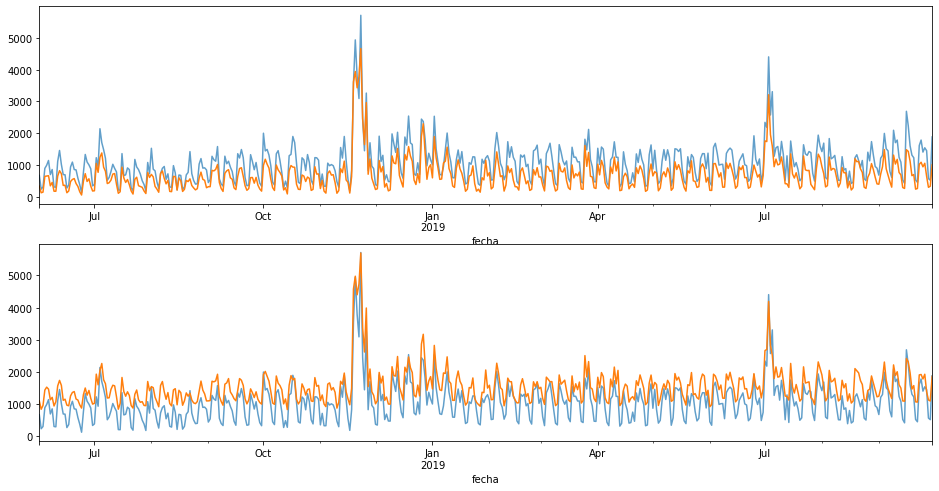

In [185]:
plt.plot(figsize=[16,8])

aggregates = df_y_hat.groupby('fecha').sum()

plt.subplot(2,1,1)
aggregates.y_test.plot(alpha=0.7)
aggregates.y_hat_raw.plot(alpha=1)

plt.subplot(2,1,2)
aggregates.y_test.plot(alpha=0.7)
aggregates.y_hat_opt.plot(alpha=1)

score(df_y_hat.y_test, df_y_hat.y_hat_raw), score(df_y_hat.y_test, df_y_hat.y_hat_opt)

### Black Friday OOS Test

2.004439762951033

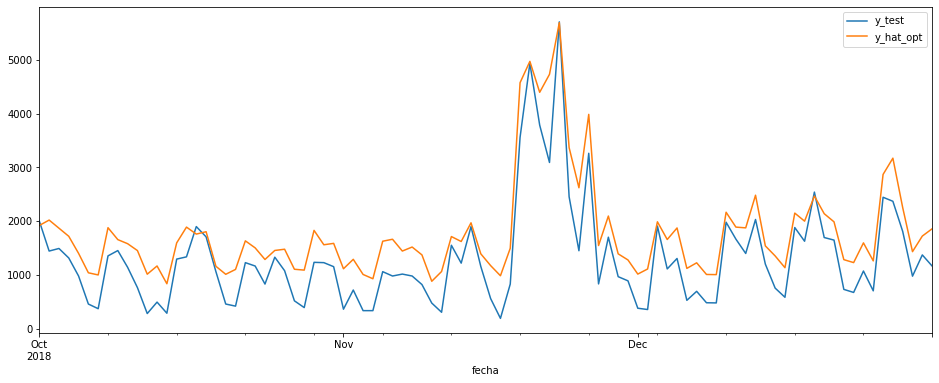

In [187]:
# Black friday dates
bf_index = (df_y_hat.fecha >= datetime(2018,10,1)) & (df_y_hat.fecha <= datetime(2018,12,31))

df_bf = df_y_hat[bf_index]

df_bf.groupby('fecha').sum()[['y_test','y_hat_opt']].plot(figsize=[16,6])

score(df_bf.y_test, df_bf.y_hat_opt)

# Generate final predictions

Apply the same transformations to the `Estimar` dataset to match the training data and generate predictions for it. We adjust the final output by +1 due to the `CF` factor.

In [190]:
df_estimar.shape

(212841, 200)

In [191]:
# Time Series data
df_estimar['ts_seasonal'] = df_estimar.fecha.dt.weekday.map(weekday_to_factor)
df_estimar['ts_trend'] = (df_estimar.fecha.dt.month-1).map(month_to_factor)


In [192]:
# Per Product Stats
df_estimar['unidades_mean'] = df_estimar.id.map(product_mean)
df_estimar['unidades_std'] = df_estimar.id.map(product_std)
df_estimar['unidades_ratio'] = df_estimar.id.map(product_ratio)

In [193]:
# Build X_estimar
X_estimar = df_estimar[X_cols + X_cols_onehot_cats]
X_estimar[X_cols_to_scl] = X_scaler.transform(X_estimar[X_cols_to_scl])

X_estimar = X_estimar.astype(np.float32)

# int_cols = ['id_dim']
# X_estimar[int_cols] = X_estimar[int_cols].astype(np.int32)

X_estimar.shape

(212841, 197)

In [194]:
# estimar_data = [
#     X_estimar.id_dim,
# #     X_estimar.categoria_uno_int,
# #     X_estimar.categoria_dos,
#     X_estimar[X_estimar.columns.drop(['id_dim'])]
# ]

# y_estimar = model.predict(estimar_data)
y_estimar = model.predict(X_estimar)
y_estimar[y_estimar < 0] = 0
y_estimar.shape

(212841, 1)

In [195]:
y_estimar = y_scaler.inverse_transform(y_estimar)
y_estimar = optimize_transform(y_estimar)

In [196]:
df_entrega = df_estimar[['fecha','id']]

df_entrega['unidades'] = y_estimar.astype(np.int32)

# df_entrega.loc[df_entrega.fecha.dt.year == 2019, "fecha"] = df_entrega.fecha + pd.offsets.DateOffset(year=2016)
df_entrega[:5]

,fecha,id,unidades
0,2019-10-01,21972,3
1,2019-10-01,23910,4
2,2019-10-01,27144,6
3,2019-10-01,30014,3
4,2019-10-01,30522,3


### Analysis of Results

AttributeError: 'DataFrame' object has no attribute 'id'

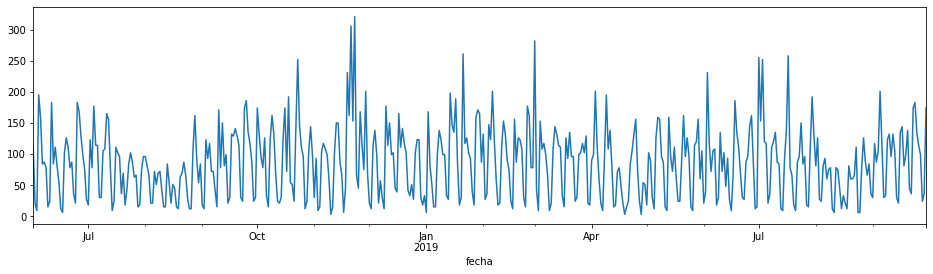

In [213]:
plt.figure(figsize=[16,4])

# df_modelar.groupby('fecha').mean().visitas_scl.plot()
# df_estimar.groupby('fecha').mean().visitas_scl.plot()

# df_modelar[df_modelar.id == 86096].groupby('fecha').mean().visitas_scl.plot()
# df_estimar[df_estimar.id == 86096].groupby('fecha').mean().visitas.plot()

# df_y_hat[df_y_hat.id == 86096].groupby('fecha').mean().y_hat_opt.plot()

df_modelar[df_modelar.id == 171826].groupby('fecha').mean().unidades_vendidas.plot()
df_entrega[df_entrega.id == 171826].groupby('fecha').mean().unidades.plot()

In [202]:
errors = pd.DataFrame(index=df_estimar.id.unique(), columns=['error'])

for i in df_estimar.id.unique():
    df_yhat_prod = df_y_hat[df_y_hat.id==i]
    
    errors.loc[i,'error'] = score(df_yhat_prod.y_test, df_yhat_prod.y_hat_opt)
    errors.loc[i,'std'] = df_yhat_prod.y_test.std()
    errors.loc[i,'mean'] = df_yhat_prod.y_test.mean()
    

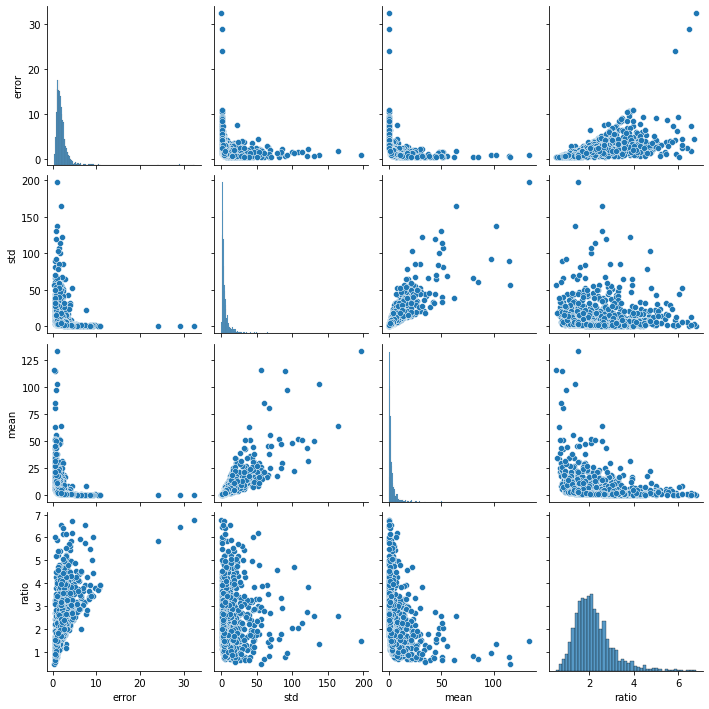

In [206]:
import seaborn as sns

errors['ratio'] = errors['std'] / errors['mean']
# errors['error_ratio'] = errors['error'] / errors['error'].mean()
# errors['error_ratio'].hist(bins=1000)

sns.pairplot(errors)

## Delivery CSV

In [211]:
df_entrega.columns = ['FECHA', 'ID', 'UNIDADES']
df_entrega.to_csv(
    'Entrega 2021-04-14/Atmira_Universitat de Barcelona_Equip Autoestima.txt',
    sep='|', index=False, date_format="%d/%m/%Y"
)